In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [2]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "/kaggle/input/kneeoa/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [3]:
df_train_kaggle.shape

(9786, 2)

Text(0, 0.5, 'count')

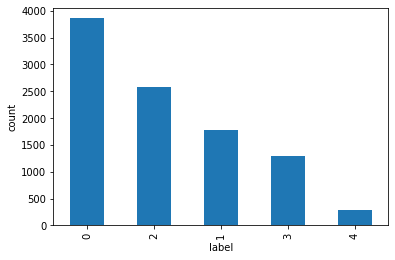

In [4]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [5]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [6]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


In [7]:
# download data from shared google drive link
!pip install gdown
!gdown --id "1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC"

     |████████████████████████████████| 142 kB 8.4 MB/s eta 0:00:01
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC
From (redirected): https://drive.google.com/uc?id=1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC&confirm=t&uuid=4b10de82-c9f8-4e49-a1c9-56c1b9e5e18c
To: /kaggle/working/KneeXray.zip
100%|████████████████████████████████████████| 120M/120M [00:01<00:00, 82.3MB/s]


In [8]:
# unzip the data
!unzip -q -o /kaggle/working/KneeXray.zip -d /kaggle/working/

In [9]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path= "/kaggle/working/KneeXray/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,/kaggle/working/KneeXray/train/Image_1.jpg,0
1,/kaggle/working/KneeXray/train/Image_2.jpg,1
2,/kaggle/working/KneeXray/train/Image_3.jpg,0
3,/kaggle/working/KneeXray/train/Image_4.jpg,1
4,/kaggle/working/KneeXray/train/Image_5.jpg,2


Text(0, 0.5, 'count')

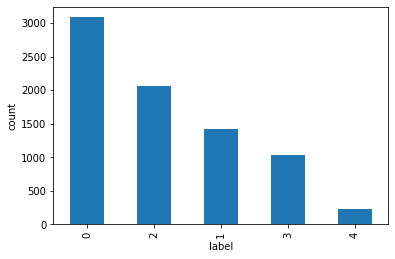

In [10]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [11]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


In [12]:
xception = Xception(weights="imagenet",)
x=  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs=pred)

91889664/91884032 [==============================] - 1s 0us/step


In [13]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [14]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [15]:
# train the model
xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)

Epoch 1/100
306/306 [==============================] - 161s 494ms/step - loss: 1.4658 - acc: 0.2639 - val_loss: 1.6795 - val_acc: 0.2372

Epoch 00001: val_acc improved from -inf to 0.23723, saving model to xception_best.ckpt
Epoch 2/100
306/306 [==============================] - 148s 484ms/step - loss: 1.1928 - acc: 0.4899 - val_loss: 1.4999 - val_acc: 0.3396

Epoch 00002: val_acc improved from 0.23723 to 0.33955, saving model to xception_best.ckpt
Epoch 3/100
306/306 [==============================] - 148s 484ms/step - loss: 1.0324 - acc: 0.5846 - val_loss: 1.2291 - val_acc: 0.5860

Epoch 00003: val_acc improved from 0.33955 to 0.58597, saving model to xception_best.ckpt
Epoch 4/100
306/306 [==============================] - 148s 483ms/step - loss: 0.9168 - acc: 0.6509 - val_loss: 1.1090 - val_acc: 0.6523

Epoch 00004: val_acc improved from 0.58597 to 0.65227, saving model to xception_best.ckpt
Epoch 5/100
306/306 [==============================] - 148s 484ms/step - loss: 0.8262 - acc

In [16]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_val_compi,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify= df_val_compi.label)

In [17]:
train_generator = train_aug.flow_from_dataframe(
dataframe = X_train,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 7045 validated image filenames.


In [18]:
valid_generator = valid_aug.flow_from_dataframe( 
dataframe=X_test,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 783 validated image filenames.


In [19]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =valid_generator.n//valid_generator.batch_size

In [20]:
# kick off training
xception_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=50,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/50
220/220 [==============================] - 97s 427ms/step - loss: 0.6121 - acc: 0.9337 - val_loss: 0.5077 - val_acc: 0.9635

Epoch 00001: val_acc improved from 0.94903 to 0.96354, saving model to xception_best.ckpt
Epoch 2/50
220/220 [==============================] - 93s 424ms/step - loss: 0.5658 - acc: 0.9631 - val_loss: 0.5211 - val_acc: 0.9701

Epoch 00002: val_acc improved from 0.96354 to 0.97005, saving model to xception_best.ckpt
Epoch 3/50
220/220 [==============================] - 93s 425ms/step - loss: 0.5304 - acc: 0.9839 - val_loss: 0.5219 - val_acc: 0.9766

Epoch 00003: val_acc improved from 0.97005 to 0.97656, saving model to xception_best.ckpt
Epoch 4/50
220/220 [==============================] - 93s 424ms/step - loss: 0.5247 - acc: 0.9875 - val_loss: 0.5150 - val_acc: 0.9779

Epoch 00004: val_acc improved from 0.97656 to 0.97786, saving model to xception_best.ckpt
Epoch 5/50
220/220 [==============================] - 93s 424ms/step - loss: 0.5197 - acc: 0.988

In [21]:
# load best saved weights
xception_model.load_weights(checkpoint_path)

In [22]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filename",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

Found 783 validated image filenames.


In [23]:
# prediction on train data
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 10s 11ms/step


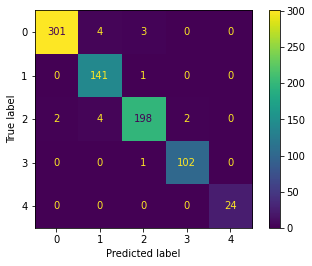

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [25]:
# read the csv file
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
dataframe= test,
directory= compi_root_path + "test",
x_col= "filename",
y_col= None,
batch_size= 1,
seed= 42,
shuffle= False,
class_mode= None,
target_size= (224,224))

# number of steps to consider 1 epoch
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [26]:
# make prediction and create dataframe out of it
pred = xception_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 21s 11ms/step


0    756
2    524
1    360
3    259
4     59
Name: label, dtype: int64

In [27]:
import sys
import shutil

# Get directory name
mydir = "/kaggle/working"

try:
    shutil.rmtree(mydir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: /kaggle/working - Device or resource busy.


In [29]:
xception_model.save_weights("knee_xray_Xceptionnet_GPA.h5")
df_submit.to_csv("submission.csv",index=False)